Resourses:
- [Business Analytics Using Forecasting Playlist](https://youtube.com/playlist?list=PLoK4oIB1jeK0LHLbZW3DTT05e4srDYxFq&si=Wc5ImfR7tSNiDgRT)
- [Time Series Analysis](https://youtube.com/playlist?list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&si=6B-WTv7uWevxyjdf)
-

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller  #check stationarity
from statsmodels.tsa.arima.model import ARIMA # model
from sklearn.metrics import mean_squared_error # compute loss

In [2]:
# Using airline passenger dataset (monthly totals)
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, parse_dates = ['Month'], index_col = 'Month')
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


<Axes: xlabel='Month'>

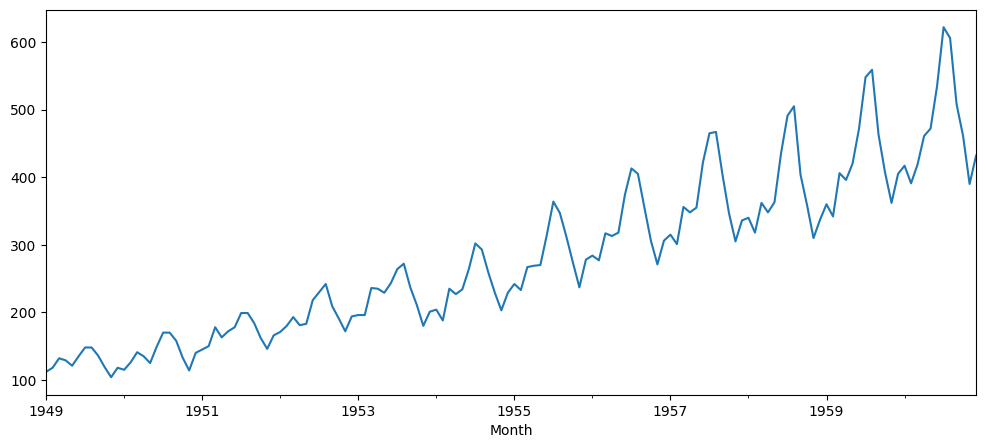

In [3]:
df['Passengers'].plot(figsize=(12,5))

The general form of the Autoregressive model of order \(p\), denoted as AR(\(p\)), is:

We assume that the time series follows an AR model (e.g., AR(1), AR(2), etc.) as an approximation of the unknown true data-generating process — but we rarely know for sure that it is the true function.

$$y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \cdots + \phi_p y_{t-p} + \varepsilon_t$$

Where:

- $ y_t $ is the value of the time series at time $t$
- $ c $ is a constant (intercept term)
- $ \phi_1, \phi_2, \ldots, \phi_p $ are the autoregressive coefficients
-  $ \varepsilon_t $ is white noise (error term), assumed to be with mean zero and constant variance


$$\hat{y_t} = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \cdots + \phi_p y_{t-p}$$


In [4]:
df['y_{t-1}'] = df['Passengers'].shift(1)
df

,Passengers,y_{t-1}
Month,,
1949-01-01,112,NaN
1949-02-01,118,112.0
1949-03-01,132,118.0
1949-04-01,129,132.0
1949-05-01,121,129.0
...,...,...
1960-08-01,606,622.0
1960-09-01,508,606.0
1960-10-01,461,508.0


In [5]:
df['y_{t-2}'] = df['y_{t-1}'].shift(1)
df

,Passengers,y_{t-1},y_{t-2}
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,112.0,NaN
1949-03-01,132,118.0,112.0
1949-04-01,129,132.0,118.0
1949-05-01,121,129.0,132.0
...,...,...,...
1960-08-01,606,622.0,535.0
1960-09-01,508,606.0,622.0
1960-10-01,461,508.0,606.0


In [6]:
df.index.freq = 'MS'  # MS stand for month start frequency

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Passengers  144 non-null    int64  
 1   y_{t-1}     143 non-null    float64
 2   y_{t-2}     142 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 4.5 KB


In [8]:
def adf_test(timeseries):
  adftest = adfuller(timeseries)

  print('Result of ADF Test:')
  adf_output = pd.Series(adftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation Used'])
  for key, value in adftest[4].items():
    adf_output['Critical Value (%s)'%key] = value

  if adf_output["p-value"] <= 0.05:
    print('The series is stationary.')
  else:
    print('The series is not stationary.')

  return adf_output

In [9]:
adftest = adf_test(df['Passengers'])
adftest

Result of ADF Test:
The series is not stationary.


,0
Test Statistic,0.815369
p-value,0.991880
#Lags Used,13.000000
Number of Observation Used,130.000000
Critical Value (1%),-3.481682
Critical Value (5%),-2.884042
Critical Value (10%),-2.578770


In [10]:
if adftest['p-value'] <= 0.05:
  print('Result: The series is stationary.')
else:
  print('Result: The series is not stationary.')

Result: The series is not stationary.


## Decomposition

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

sd = seasonal_decompose(df['Passengers'].dropna(), model = 'additive', period= 12 )


In [12]:
trend = sd.trend
seasonal = sd.seasonal
residuals = sd.resid

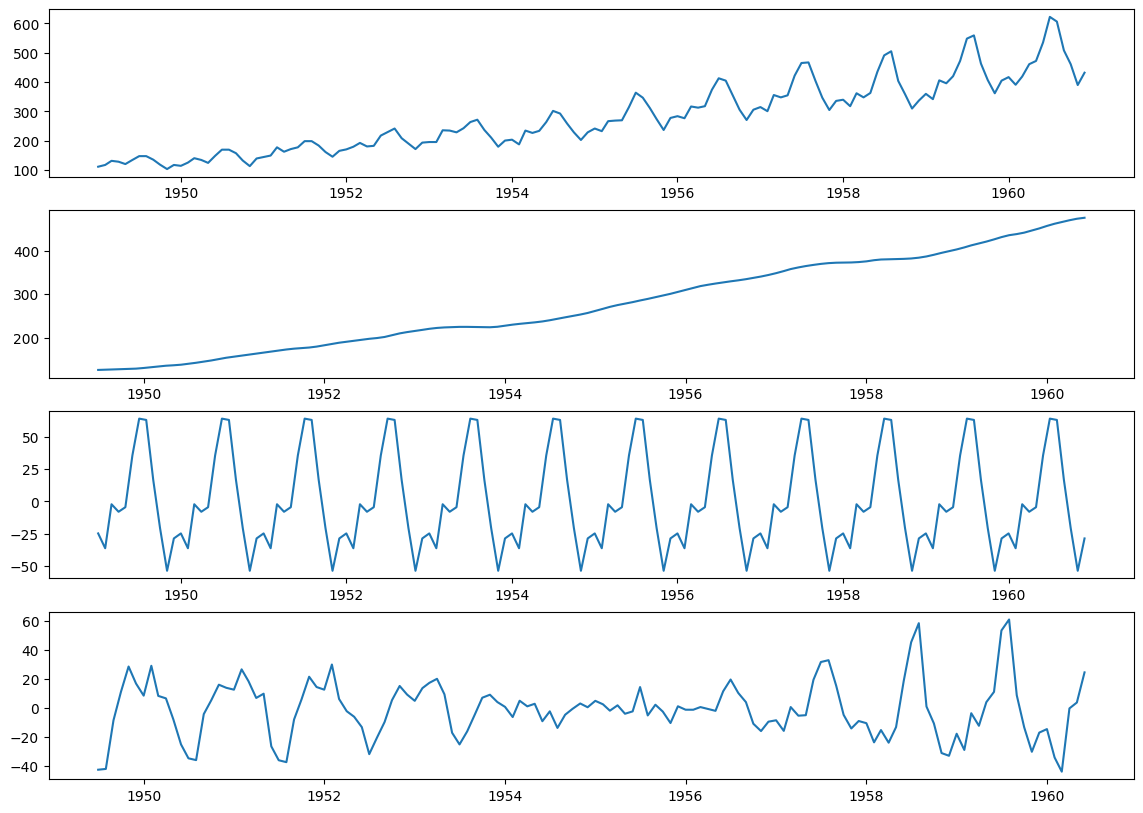

In [13]:
plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(df['Passengers'])
plt.subplot(412)
plt.plot(trend)
plt.subplot(413)
plt.plot(seasonal)
plt.subplot(414)
plt.plot(residuals)
plt.show()

I have to do:
 * differencing or
 * detrending
 * np.log, np.sqrt, boxcox transformation if low variance

In [14]:
df['diff_1'] = df['Passengers'].diff(periods=1)

In [15]:
# Preprocessing to make the data stationary
df['diff_12'] = df['Passengers'].diff(periods=12)  # differencing

# seasonal differencing
# choosing periods=12 because it's yearly data and
# seasonal graph repeating in period of 12

df

,Passengers,y_{t-1},y_{t-2},diff_1,diff_12
Month,,,,,
1949-01-01,112,NaN,NaN,NaN,NaN
1949-02-01,118,112.0,NaN,6.0,NaN
1949-03-01,132,118.0,112.0,14.0,NaN
1949-04-01,129,132.0,118.0,-3.0,NaN
1949-05-01,121,129.0,132.0,-8.0,NaN
...,...,...,...,...,...
1960-08-01,606,622.0,535.0,-16.0,47.0
1960-09-01,508,606.0,622.0,-98.0,45.0
1960-10-01,461,508.0,606.0,-47.0,54.0


In [16]:
# Stationary Check on Differenced Data
adf_test(df['diff_12'].dropna())

Result of ADF Test:
The series is stationary.


,0
Test Statistic,-3.383021
p-value,0.011551
#Lags Used,1.000000
Number of Observation Used,130.000000
Critical Value (1%),-3.481682
Critical Value (5%),-2.884042
Critical Value (10%),-2.578770


In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

sd = seasonal_decompose(df['diff_12'].dropna(), model='additive', period=12)

In [18]:
trend = sd.trend
seasonal = sd.seasonal
residuals = sd.resid

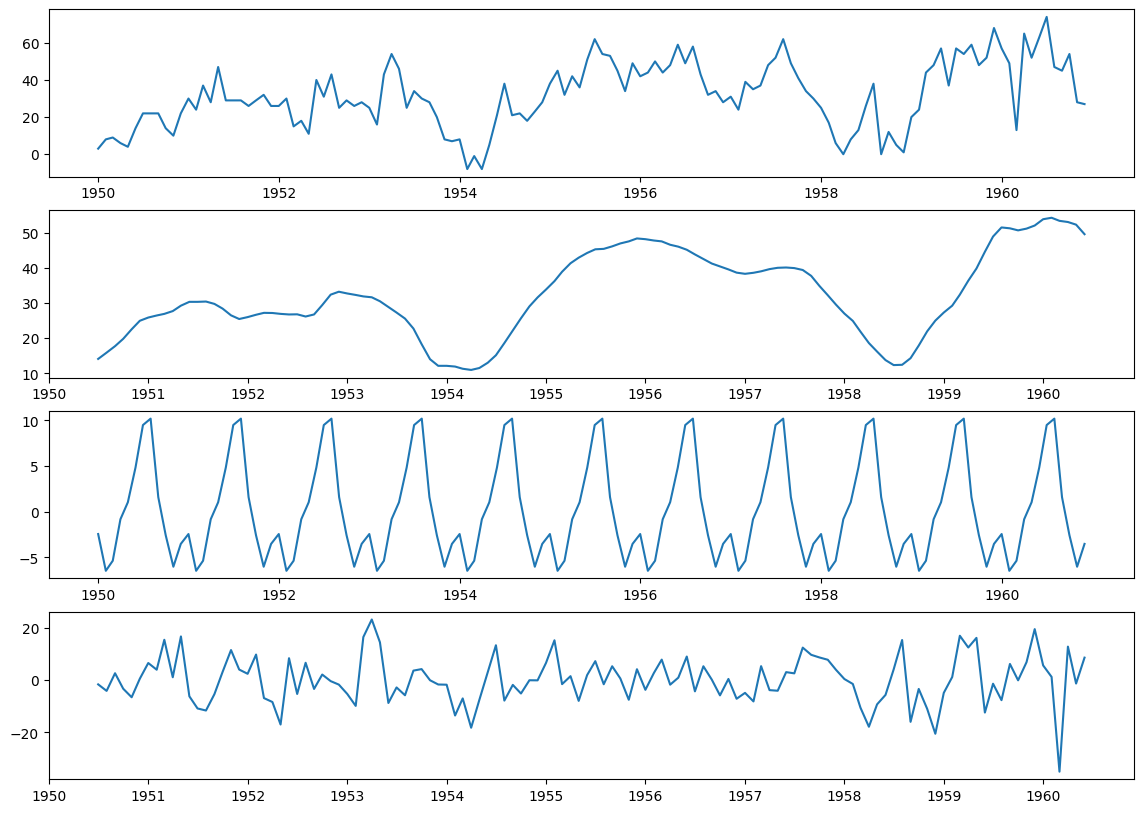

In [19]:
plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(df['diff_12'].dropna())
plt.subplot(412)
plt.plot(trend)
plt.subplot(413)
plt.plot(seasonal)
plt.subplot(414)
plt.plot(residuals)
plt.show()

In [20]:
y = df['diff_12'].dropna()
y.index.freq = 'MS'

In [21]:
# 3. Train-Test Split
# Split the data into a training set (first 80%) and a testing set (last 20%)
train_size = int(len(y)*0.8)
train, test = y[0:train_size], y[train_size:]

print(f"\nTraining set size: {len(train)}")
print(f"Testing set size: {len(test)}")


Training set size: 105
Testing set size: 27


In [22]:
# 4. Model Building, Forcasting, and Scoring
def evaluate_model(model_fit, test_data):
  """Forcasts and evaluates the model."""
  forecast = model_fit.forecast(steps=len(test_data))
  mse = mean_squared_error(test_data, forecast)
  rmse = np.sqrt(mse)
  return mse, rmse

In [23]:
train.index

DatetimeIndex(['1950-01-01', '1950-02-01', '1950-03-01', '1950-04-01',
               '1950-05-01', '1950-06-01', '1950-07-01', '1950-08-01',
               '1950-09-01', '1950-10-01',
               ...
               '1957-12-01', '1958-01-01', '1958-02-01', '1958-03-01',
               '1958-04-01', '1958-05-01', '1958-06-01', '1958-07-01',
               '1958-08-01', '1958-09-01'],
              dtype='datetime64[ns]', name='Month', length=105, freq='MS')

In [24]:
def fit_ar_model_statsmodels(y,p):
  model = ARIMA(y, order=(p,0,0), trend='c') # 'c' = constant
  model_fit = model.fit()
  return model.fit

In [25]:
model = ARIMA(train, order=(2,0,0), trend='c')
model

In [26]:
model_fit = model.fit()

In [27]:
model_fit.forecast(steps=len(test))

,predicted_mean
1958-10-01,10.060677
1958-11-01,11.670002
1958-12-01,14.155478
1959-01-01,16.071235
1959-02-01,17.719743
1959-03-01,19.107500
1959-04-01,20.280687
1959-05-01,21.271671
1959-06-01,22.108882
1959-07-01,22.816159


In [28]:
# A. AR Model (p,d,0)
print("\n--- Building AR Model ---")
try:
  ar_model = ARIMA(train, order=(2,0,0), trend = 'c')  # Using p=2
  ar_model_fit = ar_model.fit()
  ar_mse, ar_rmse = evaluate_model(ar_model_fit, test)
  print(f"AR Model MSE: {ar_mse:.4f}, RMSE:{ar_rmse:.4f}")
  print(f'AR Model Summary: \n{ar_model_fit.summary()}')
except Exception as e:
  print(f"Error with AR model: {e}")


--- Building AR Model ---
AR Model MSE: 695.7220, RMSE:26.3765
AR Model Summary: 
                               SARIMAX Results                                
Dep. Variable:                diff_12   No. Observations:                  105
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -390.087
Date:                Tue, 04 Nov 2025   AIC                            788.173
Time:                        00:19:21   BIC                            798.789
Sample:                    01-01-1950   HQIC                           792.475
                         - 09-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.6663      4.935      5.404      0.000      16.994      36.338
ar.L1          0.6814      0.102      6.660     

In [29]:
# B. MA Model (0, d, q)
print('\n--- Building MA Model ---')
try:
  ma_model = ARIMA(train, order=(0, 0, 2)) # Using q = 2
  ma_model_fit = ma_model.fit()
  ma_mse, ma_rmse = evaluate_model(ma_model_fit, test)
  print(f"MA Model MSE: {ma_mse:.4f}, RMSE: {ma_rmse:.4f}")
  print(f"MA Model Summary:\n{ma_model_fit.summary()}")
except Exception as e:
  print(f'Error with MA model : {e}')




--- Building MA Model ---
MA Model MSE: 566.6537, RMSE: 23.8045
MA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                diff_12   No. Observations:                  105
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -397.518
Date:                Tue, 04 Nov 2025   AIC                            803.036
Time:                        00:19:22   BIC                            813.652
Sample:                    01-01-1950   HQIC                           807.337
                         - 09-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.3016      2.219     12.752      0.000      23.952      32.651
ma.L1          0.6043      0.099      6.130     

In [30]:
# C. ARMA Model (p,d,q)
print('\n--- Building ARMA Model ---')
try:
  arma_model = ARIMA(train, order=(2, 0, 2))  # Using p=2, q=2
  arma_model_fit = arma_model.fit()
  arma_mse, arma_rmse = evaluate_model(arma_model_fit, test)
  print(f'ARMA Model MSE: {arma_mse:.4f}, RMSE: {arma_rmse:.4f}')
  print(f'ARMA Model Summary:\n{arma_model_fit.summary()}')
except Exception as e:
  print(f'Error with ARMA model: {e}')


--- Building ARMA Model ---
ARMA Model MSE: 639.7975, RMSE: 25.2942
ARMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                diff_12   No. Observations:                  105
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -389.043
Date:                Tue, 04 Nov 2025   AIC                            790.087
Time:                        00:19:23   BIC                            806.010
Sample:                    01-01-1950   HQIC                           796.539
                         - 09-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.0859      4.426      6.119      0.000      18.410      35.761
ar.L1          0.3947      0.458      0.86

In [37]:
# D. ARIMA Model (p, d, q)
print('\n--- Building ARIMA Model ---')
try:
  # 'd' is the differencing order found from the stationary check.
  arima_model = ARIMA(train, order=(2,1,2)) # Using p=2, q=2
  arima_model_fit = arima_model.fit()
  arima_mse, arima_rmse = evaluate_model(arima_model_fit, test)
  print(f'ARIMA Model MSE: {arima_mse:.4f}, RMSE: {arima_rmse:.4f}')
  print(f'ARIMA Model Summary:\n{arima_model_fit.summary()}')
except Exception as e:
  print(f'Error with ARIMA model: {e}')


--- Building ARIMA Model ---
ARIMA Model MSE: 725.1162, RMSE: 26.9280
ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                diff_12   No. Observations:                  105
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -386.884
Date:                Tue, 04 Nov 2025   AIC                            783.767
Time:                        00:20:27   BIC                            796.989
Sample:                    01-01-1950   HQIC                           789.124
                         - 09-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2236      0.422      0.530      0.596      -0.603       1.050
ar.L2          0.5374      0.352      1

In [38]:
# Final summary of results
print('\n--- Model Performance Summary ---')
print(f'AR Model: MSE = {ar_mse:.4f}, RMSE = {ar_rmse:.4f}')
print(f'MA Model: MSE = {ma_mse:.4f}, RMSE = {ma_rmse:.4f}')
print(f'ARMA Model: MSE = {arma_mse:.4f}, RMSE = {arma_rmse:.4f}')
print(f'ARIMA Model: MSE = {arima_mse:.4f}, RMSE = {arima_rmse:.4f}')


--- Model Performance Summary ---
AR Model: MSE = 695.7220, RMSE = 26.3765
MA Model: MSE = 566.6537, RMSE = 23.8045
ARMA Model: MSE = 639.7975, RMSE = 25.2942
ARIMA Model: MSE = 725.1162, RMSE = 26.9280
